# Using shallow water equations to understand large-scale dynamics
### MAQ - 32806, Chiel van Heerwaarden, 2016
In this tutorial you will use the previously derived shallow water equations to solve the famous Rossby adjustment problem in which a perturbation is added to a layer of fluid.

In [28]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
figsize_s = 6,4
figsize_l = 10,4

In [29]:
f_multiplier = 1.
lat = 52.
f = f_multiplier * 2.*7.29e-5*np.sin(np.pi/180.*lat)
g = 9.81
L = 6.371e6 * (2.*np.pi) * np.cos(np.pi/180.*lat)
h_ref = 200.
h_prime = 0.1

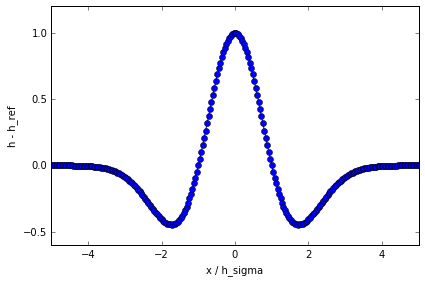

In [31]:
nx = 2001
x = np.linspace(-L/2., L/2., nx)
dx = x[1]-x[0]
u0 = np.zeros(nx)
v0 = np.zeros(nx)
h_ref   = 200.
h_prime = 0.1

# Smooth step function.
# h0 = np.copy(x)
# h_sigma = 20.*dx
# for i in range(nx):
#    h0[i] = h_ref - h_prime*np.math.erf(h0[i]/(20*dx))

# Mexican hat (Ricker wavelet).
h_sigma = 25.*dx # The wavelet is approximately 8 h_sigma in total width.
h_width = 2./((3.*h_sigma)**.5*np.pi**.25)
h0 = 2./((3.*h_sigma)**.5*np.pi**.25) * (1. - x**2/h_sigma**2) * np.exp(-x**2/(2.*h_sigma**2))
h0 = h_ref + h0/np.max(h0)

i_start, i_end = nx/2 - 8*np.int(h_sigma/dx), nx/2 + 8*np.int(h_sigma/dx)

# Just a check that the disturbance is well enough resolved.
pl.figure(figsize=figsize_s)
pl.plot(x/h_sigma, h0 - h_ref, 'bo-')
pl.xlim(-5, 5)
pl.xlabel('x / h_sigma')
pl.ylabel('h - h_ref');
pl.tight_layout()

In [17]:
try:
    Lr = (g*h_ref)**.5 / f
except ZeroDivisionError:
    Lr = np.infty
finally:
    print "Circumference of Earth at latitude = {0:.1f} km".format(L/1.e3)
    print "Rossby radius of deformation = {0:.1f} km".format(Lr/1.e3)
    print "Size of disturbance = {0:.1f} km".format(8*h_sigma/1.e3)
    print "Lr / L = {0}".format(Lr/L)
    print "Lr / h_sigma = {0}".format(Lr/h_sigma)

Circumference of Earth at latitude = 24645.0 km
Rossby radius of deformation = 385.5 km
Size of disturbance = 2464.5 km
Lr / L = 0.0156433722985
Lr / h_sigma = 1.25146978388


In [18]:
u = np.copy(u0)
v = np.copy(v0)
h = np.copy(h0)

nt = 50000
ni = 500
dt = 8.

u_out = np.zeros((nt/ni+1, nx))
v_out = np.zeros((nt/ni+1, nx))
h_out = np.zeros((nt/ni+1, nx))
u_out[0,:], v_out[0,:], h_out[0,:] = u0, v0, h0

for n in range(1,nt+1):
    u += dt * (  f*v - g*np.gradient(h,dx) )
    v += dt * ( -f*u )
    h += dt * ( -h_ref*np.gradient(u,dx) )
    
    if (n%ni == 0):
        u_out[n/ni,:] = u[:]
        v_out[n/ni,:] = v[:]
        h_out[n/ni,:] = h[:]

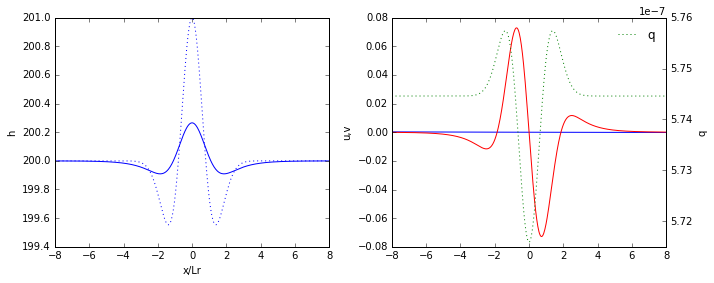

In [33]:
pl.figure(figsize=figsize_l)
pl.subplot(121)
pl.plot(x/Lr, h , 'b-')
pl.plot(x/Lr, h0, 'b:')
pl.xlabel('x/Lr')
pl.ylabel('h')
pl.xlim(-8, 8)
pl.subplot(122)
pl.plot(x/Lr, u, 'b-', label='u')
pl.plot(x/Lr, v, 'r-', label='v')
pl.ylabel('u,v')
pl.twinx()
pl.plot(x/Lr, q, 'g:', label='q')
pl.xlabel('x/Lr')
pl.ylabel('q')
pl.xlim(-8, 8)
pl.legend(loc=0, frameon=False);
pl.tight_layout()

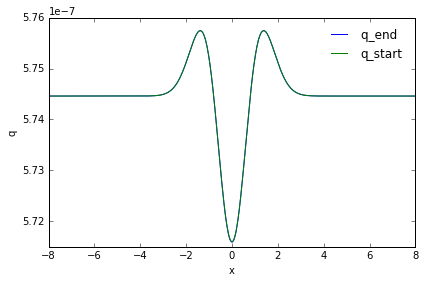

In [34]:
q0 = f/h0
q  = (np.gradient(v,dx) + f) / h
pl.figure(figsize=figsize_s)
pl.plot(x/Lr, q , label='q_end  ')
pl.plot(x/Lr, q0, label='q_start')
pl.xlabel('x')
pl.ylabel('q')
pl.xlim(-8, 8)
pl.legend(loc=0, frameon=False);
pl.tight_layout()

In [35]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    pl.close(anim._fig)
    return HTML(anim_to_html(anim))
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = pl.figure(figsize=figsize_l)
xmin, xmax = min(x), max(x)
hmin, hmax = min(h0), max(h0)
hmin -= 0.05*(hmax-hmin)
hmax += 0.05*(hmax-hmin)
ax = pl.axes(xlim=(xmin, xmax), ylim=(hmin, hmax), xlabel='x', ylabel='h')
ax.plot(x, h_out[0,:], 'b--')
line, = ax.plot([], [], lw=2)
fig.tight_layout()

# initialization function: plot the background of each frame
def init():
    line.set_data(x, h_out[0,:])
    return line,

def animate(i):
    line.set_data(x, h_out[i,:])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=h_out.shape[0], interval=1, blit=True)

# call our new function to display the animation
display_animation(anim)

Summing from x/Lr = (-6.39248354457, 6.39248354457)
A fraction 0.0849756619109 of the potential energy is retained near the disturbance.
A fraction 0.265475682289 of the initial height is retained.


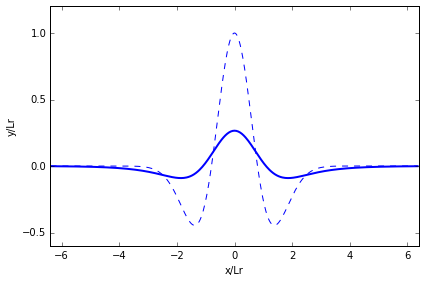

In [36]:
print "Summing from x/Lr = ({0}, {1})".format(x[i_start]/Lr, x[i_end]/Lr)
print "A fraction {0} of the potential energy is retained near the disturbance."\
    .format(sum((h_out[-1,i_start:i_end]-h_ref)**2)/sum((h_out[0,i_start:i_end]-h_ref)**2))
print "A fraction {0} of the initial height is retained."\
    .format( (h_out[-1,nx/2]-h_ref) / (h_out[0,nx/2]-h_ref) )
    
pl.plot(x[i_start:i_end]/Lr, h_out[-1,i_start:i_end]-h_ref, lw=2)
pl.plot(x[i_start:i_end]/Lr, h_out[ 0,i_start:i_end]-h_ref, 'b--')
pl.xlim(x[i_start]/Lr, x[i_end]/Lr)
pl.xlabel('x/Lr')
pl.ylabel('y/Lr')
pl.tight_layout();

___
End of tutorial.
___